In [5]:
!pip install sklearn

  Using cached sklearn-0.0.post7.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2950 sha256=0fc3890902d12a83e20c29ccb67c4fc4c8aa6dddac2ee94b3c205a44585b5365
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


K-Nearest Neighbors Regression:
Mean Squared Error (Cross-Validated): 121.42147451657226
MSE Standard Deviation: 18.10469842522515
R-squared (Cross-Validated): 0.09754805630215331
R-squared Standard Deviation: 0.07705933509436805


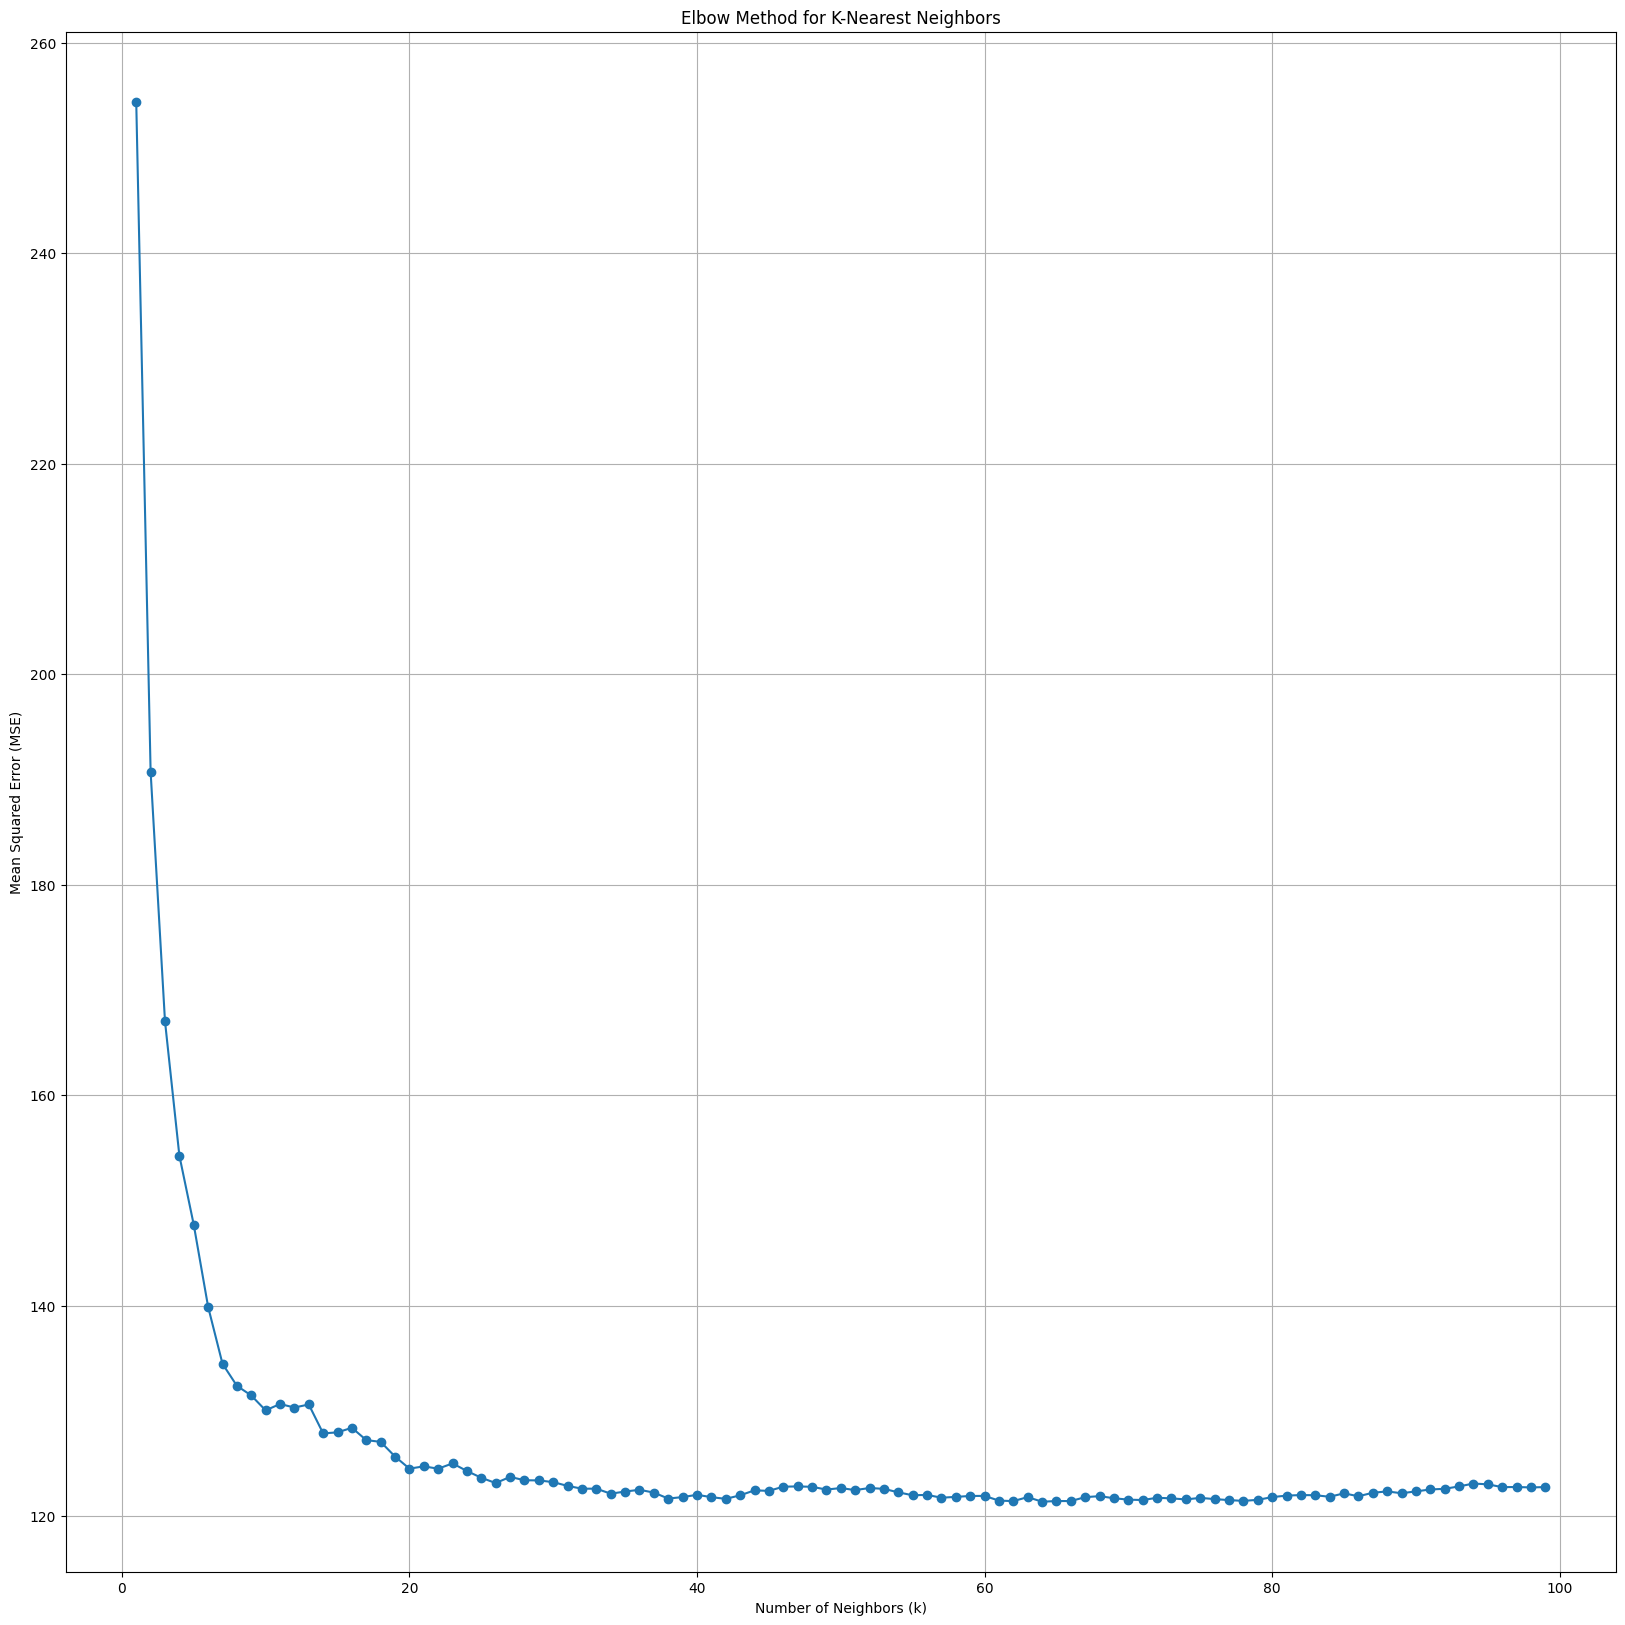

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

df = pd.read_csv('dat.csv')
df

df = df.drop(['player_name'], axis=1)
df = df.fillna(df.mean(numeric_only=True))

new_df = df.copy()
out_rows = df[df['transfer_movement'] == 'out'].index
df_modified = df.copy()

for i in out_rows:
    df_modified.loc[i, ['club_involved_name', 'club_name']] = \
        df.loc[i, ['club_name', 'club_involved_name']].values

df_modified.loc[out_rows, 'transfer_movement'] = "in"

df = df_modified.copy()
df = df.drop('transfer_movement', axis=1)

Q1 = df["fee_cleaned"].quantile(0.25)
Q3 = df["fee_cleaned"].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df["fee_cleaned"] < (Q1 - 1.5 * IQR)) | (df["fee_cleaned"] > (Q3 + 1.5 * IQR)))]

df.dropna(subset=["fee_cleaned"], inplace=True)

features = df[
    [
        "matches_played", "goals", "assists", "yellow_card", "red_card", "90s_played",
        "minutes", "xGoals", "xAssists", "shotsT_90", "passes", "pass_complete%",
        "tackle", "block", "touches", "carries", "goals_against", "goals_against90",
        "Saves", "Saves%", "PSxG", "plus_minus90", "age"
    ]
]

target = df["fee_cleaned"]

imputer = SimpleImputer(strategy="mean")
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

selector = SelectKBest(score_func=f_regression, k=10)
features_selected = selector.fit_transform(features_scaled, target)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

target = target.values.ravel()

k = 62
knn_model = KNeighborsRegressor(n_neighbors=k)

mse_scores_knn = -cross_val_score(knn_model, features_selected, target, cv=kfold, scoring='neg_mean_squared_error')
r_squared_scores_knn = cross_val_score(knn_model, features_selected, target, cv=kfold, scoring='r2')

mean_mse_knn, std_mse_knn = np.mean(mse_scores_knn), np.std(mse_scores_knn)
mean_r_squared_knn, std_r_squared_knn = np.mean(r_squared_scores_knn), np.std(r_squared_scores_knn)

print("K-Nearest Neighbors Regression:")
print("Mean Squared Error (Cross-Validated):", mean_mse_knn)
print("MSE Standard Deviation:", std_mse_knn)
print("R-squared (Cross-Validated):", mean_r_squared_knn)
print("R-squared Standard Deviation:", std_r_squared_knn)

k_values = []
mse_values = []
k_range = range(1, 100)
for k in k_range:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    mse_scores_knn = -cross_val_score(knn_model, features_selected, target, cv=kfold, scoring='neg_mean_squared_error')
    mean_mse_knn = np.mean(mse_scores_knn)

    k_values.append(k)
    mse_values.append(mean_mse_knn)

plt.figure(figsize=(20, 20))
plt.plot(k_values, mse_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow Method for K-Nearest Neighbors')
plt.grid(True)
plt.show()